<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 08 - Difusão Condicionamento Espacial**

## **Configurações iniciais**

Seguindo o condicionamento, vamos inplementar aqui o condicionamento espacial, com na aula anterior, começando com as importações e configuração do ambiente.

In [ ]:
!pip install torchview -q

In [ ]:
# Bibliotecas padrão
import re
import ast
import math
import numpy as np
import textwrap
import kagglehub
import shutil
import os
import pandas as pd
from collections import defaultdict, Counter

# Bibliotecas de visualização
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Im2

# Bibliotecas PyTorch, torchvision, estatisticas e Visão Computacional
import cv2
import torch.nn as nn
import torch, torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_

from torchview import draw_graph
from torchvision.utils import make_grid
from torchvision.transforms import v2

import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Baixar dataset
dataset_path = kagglehub.dataset_download("ashfakyeafi/brain-mri-images")

# Definir destino no /content
destination_path = '/content/brain-mri-images'

# Copiar para /content
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)
print("Dataset copiado para:", destination_path)

100%|██████████| 348M/348M [00:16<00:00, 21.8MB/s]

Extracting files...


Dataset copiado para: /content/brain-mri-images


In [ ]:
class Dataset(Dataset):
    def __init__(self, images_dir, transform=None, slice_plane=None):
        self.transform = transform
        self.slice_plane = slice_plane
        self.image_files = []
        self.labels = []
        self.label_to_idx = {}

        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    parts = file.lower().split('_')
                    if len(parts) > 3:
                        plane = parts[3]
                        self.image_files.append(os.path.join(root, file))

                        label = plane  # Usando o plano como rótulo
                        if label not in self.label_to_idx:
                            self.label_to_idx[label] = len(self.label_to_idx)
                        self.labels.append(self.label_to_idx[label])

        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)

        print(f"Dataset carregado: {len(self.image_files)} imagens")
        print(f"Classes encontradas: {self.label_to_idx}")

        # Impressão da quantidade de amostras por classe (rótulo original)
        label_counts = Counter(self.labels)
        for idx, count in label_counts.items():
            print(f"Classe '{self.idx_to_label[idx]}': {count} amostras")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path).lower()
        image = Image.open(img_path).convert('L')

        parts = img_name.split('_')
        slice_plane = parts[3]

        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "slice": slice_plane,
            "label": self.labels[idx]
        }


In [ ]:
# Definir Dimensão da Imagem
img_size = 64

# Transformação básica para normalizar para [-1,1]
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Dataset e DataLoader
dataset = Dataset(
    '/content/brain-mri-images',
    transform=transform,
    slice_plane=None
    )

# Carrega dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Dataset carregado: 7692 imagens
Classes encontradas: {'x': 0, 'y': 1, 'z': 2}
Classe 'x': 2564 amostras
Classe 'y': 2564 amostras
Classe 'z': 2564 amostras


Visualizando 16 amostras do dataset


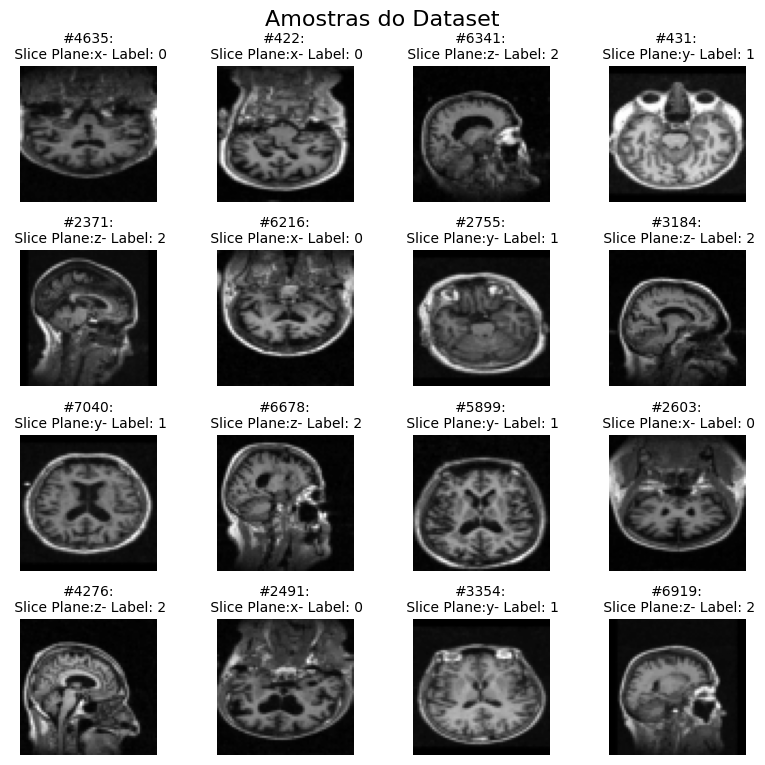

In [ ]:
# Seleciona aleatoriamente até 16 índices do dataset
indices = np.random.choice(len(dataset), size=min(16, len(dataset)), replace=False)
print(f"Visualizando {len(indices)} amostras do dataset")

# Define grid para exibição: 8 colunas e número de linhas necessário
cols = 4
rows = (len(indices) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))

# Garante que axes tenha sempre shape 2D para facilitar o loop
axes = np.atleast_2d(axes)

# Itera sobre cada índice selecionado e plota no grid
for i, idx in enumerate(indices):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sample = dataset[idx]

    # Recupera imagem e label
    image = sample['image']
    slice_plane = sample['slice']
    label = sample['label']

    # Desnormaliza de [-1,1] para [0,1]
    img_vis = torch.clamp((image * 0.5) + 0.5, 0, 1)
    img_np = img_vis.permute(1, 2, 0).cpu().numpy()

    # Plota a imagem
    ax.imshow(img_np, cmap='gray')
    ax.axis('off')

    # Formata o texto do label em múltiplas linhas
    slice_plane = "\n".join(textwrap.wrap(str(slice_plane), width=10))
    ax.set_title(f"#{idx}:\n Slice Plane:{slice_plane}- Label: {label}", fontsize=10, pad=5)

# Oculta subplots vazios
total_slots = rows * cols
for i in range(len(indices), total_slots):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

# Título geral do grid
plt.suptitle("Amostras do Dataset", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## **Arquitetura com Condicionamento Espacial**
Até agora, mesmo com condicionamento por rótulos, não tínhamos controle sobre onde elementos específicos apareceriam na imagem ou qual seria sua estrutura espacial. O Condicionamento Espacial resolve este problema introduzindo uma arquitetura auxiliar que processa informações espaciais (como mapas de bordas, máscaras ou esqueletos) e injeta esse conhecimento estrutural no processo de difusão.

### **Configurações Iniciais**

In [ ]:
# Parâmetros do processo de difusão
T = 1000
beta_start, beta_end = 1e-4, 0.02

# Schedule de beta
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, 0)

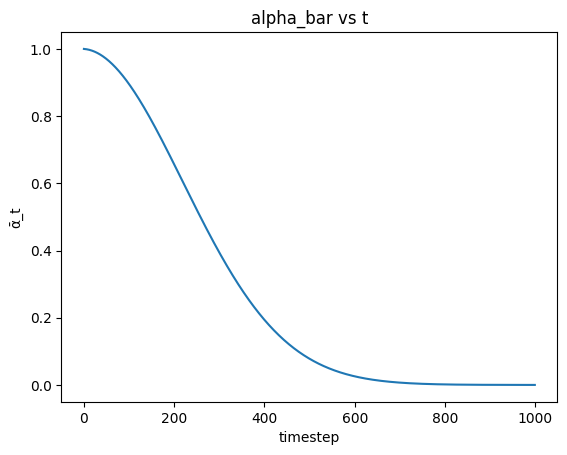

In [ ]:
# Visualizar alpha acumulado
plt.plot(alpha_bar.cpu())
plt.title("alpha_bar vs t")
plt.xlabel("timestep")
plt.ylabel("ᾱ_t")
plt.show()

### **Mecanismo de Atenção Espacial**

Antes de implementar a rede neural propriamente dita, reutilizamos os componentes que desenvolvemos na aula anterior: embeddings temporais, de rótulos e blocos residuais condicionais.

In [ ]:
# Embedding senoidal de tempo
def sinusoidal_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device,
                                                      dtype=torch.float32) / (half - 1))
    emb = t[:, None].float() * freqs[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=1)

### **Embedding de Rótulos (Label Embedding)**

In [ ]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)
        self.num_classes = num_classes

    def forward(self, labels):
        return self.embedding(labels)

In [ ]:
class ConditionalTimeEmbedding(nn.Module):
    def __init__(self, time_dim, label_dim):
        super().__init__()
        self.time_dim = time_dim
        self.label_dim = label_dim

        # MLP para processar embedding temporal
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # MLP para processar embedding de rótulo
        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, label_dim * 2),
            nn.SiLU(),
            nn.Linear(label_dim * 2, time_dim)
        )

        # Camada de fusão
        self.fusion = nn.Sequential(
            nn.Linear(time_dim * 2, time_dim),
            nn.SiLU()
        )

    def forward(self, t, label_emb):
        # Processar embedding temporal
        t_emb = sinusoidal_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        # Processar embedding de rótulo
        l_emb = self.label_mlp(label_emb)

        # Fusão dos embeddings
        combined = torch.cat([t_emb, l_emb], dim=1)
        return self.fusion(combined)

### **Bloco Residual Condicional**

In [ ]:
class ConditionalResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, groups=8, dropout=0.1):
        super().__init__()
        self.same_channels = (in_ch == out_ch)

        # Primeira convolução
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.act1 = nn.SiLU()

        # Projeção do embedding condicional
        self.time_proj = nn.Linear(time_dim, out_ch)

        # Segunda convolução
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act2 = nn.SiLU()

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x, cond_emb):
        residual = self.skip(x)

        # Primeira convolução
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)

        # Adicionar condicionamento
        cond = self.time_proj(cond_emb)[:, :, None, None]
        h = h + cond

        # Segunda convolução
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.dropout(h)
        h = self.act2(h)

        # Conexão residual
        return (h + residual) / 1.414

### **Módulos Down e Up Condicionais**

In [ ]:
class ConditionalDown(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.block1 = ConditionalResidualBlock(in_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)
        self.pool = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, cond_emb):
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        p = self.pool(x)
        return x, p

class ConditionalUp(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.block1 = ConditionalResidualBlock(out_ch + skip_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)

    def forward(self, x, skip, cond_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        return x

### **Conditional UNet**

O Condicionamento Espacial usa apenas a metade encoder da U-Net, focando exclusivamente em extrair features espaciais hierárquicos das condições de entrada. Esta arquitetura mais minimalista é intencional, pois queremos processar informações espaciais sem interferir no processo generativo principal.

In [ ]:
### U-Net com hints espaciais
class ControlUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_classes=1, time_dim=256, label_dim=128):
        super().__init__()
        self.label_embedding = LabelEmbedding(num_classes, label_dim)
        self.time_embedding = ConditionalTimeEmbedding(time_dim, label_dim)

        self.down1 = ConditionalDown(in_channels, base_channels, time_dim)
        self.down2 = ConditionalDown(base_channels, base_channels * 2, time_dim)
        self.down3 = ConditionalDown(base_channels * 2, base_channels * 4, time_dim)
        self.down4 = ConditionalDown(base_channels * 4, base_channels * 8, time_dim)

        self.bot1 = ConditionalResidualBlock(base_channels * 8, base_channels * 16, time_dim)
        self.bot2 = ConditionalResidualBlock(base_channels * 16, base_channels * 8, time_dim)

        self.up4 = ConditionalUp(base_channels * 8, base_channels * 8, base_channels * 4, time_dim)
        self.up3 = ConditionalUp(base_channels * 4, base_channels * 4, base_channels * 2, time_dim)
        self.up2 = ConditionalUp(base_channels * 2, base_channels * 2, base_channels, time_dim)
        self.up1 = ConditionalUp(base_channels, base_channels, base_channels, time_dim)

        self.out = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, t, label_emb, control_hints):
        cond_emb = self.time_embedding(t, label_emb)

        s1, p1 = self.down1(x, cond_emb)
        s1 += control_hints[0]
        s2, p2 = self.down2(p1, cond_emb)
        s2 += control_hints[1]
        s3, p3 = self.down3(p2, cond_emb)
        s3 += control_hints[2]
        s4, p4 = self.down4(p3, cond_emb)
        s4 += control_hints[3]

        b = self.bot1(p4, cond_emb)
        b = self.bot2(b, cond_emb)

        u4 = self.up4(b, s4, cond_emb)
        u3 = self.up3(u4, s3, cond_emb)
        u2 = self.up2(u3, s2, cond_emb)
        u1 = self.up1(u2, s1, cond_emb)

        return self.out(u1)

**Por que Injetar nas Skip Connections?**
As skip connections na U-Net preservam detalhes espaciais finos que seriam perdidos no bottleneck. Ao injetar nossos hints espaciais diretamente nessas conexões, garantimos que informações estruturais influenciem diretamente a reconstrução espacial da imagem final.

O Condicionamento Espacial retorna features em quatro escalas diferentes, correspondendo exatamente às skip connections da Condicionamento Espacial. Esta correspondência hierárquica garante que informações espaciais sejam injetadas nos níveis apropriados de abstração.

In [ ]:
class CondicionamentoEspacial(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, time_dim=256):
        super().__init__()
        self.down1 = ConditionalDown(in_channels, base_channels, time_dim)
        self.down2 = ConditionalDown(base_channels, base_channels * 2, time_dim)
        self.down3 = ConditionalDown(base_channels * 2, base_channels * 4, time_dim)
        self.down4 = ConditionalDown(base_channels * 4, base_channels * 8, time_dim)

    def forward(self, x, cond_emb):
        f1, p1 = self.down1(x, cond_emb)
        f2, p2 = self.down2(p1, cond_emb)
        f3, p3 = self.down3(p2, cond_emb)
        f4, p4 = self.down4(p3, cond_emb)
        return [f1, f2, f3, f4]

### **Pipeline Unificado: Integrando Condicionamento Espacial e U-Net**

Agora vamos unificar tudo, criando uma classe que una todo o pipeline.

In [ ]:
# Pipeline Unificado
class CondSpacialNetPipeline(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_classes=1, time_dim=256, label_dim=128):
        super().__init__()
        self.condspacial = CondicionamentoEspacial(in_channels, base_channels, time_dim)
        self.unet = ControlUNet(in_channels, base_channels, num_classes, time_dim, label_dim)
        self.label_dim = label_dim
        self.num_classes = num_classes

    def forward(self, x, t, labels=None, spatial_condition=None):
        if labels is not None:
            label_emb = self.unet.label_embedding(labels)
        else:
            label_emb = torch.zeros(x.size(0), self.label_dim, device=x.device)

        cond_emb = self.unet.time_embedding(t, label_emb)

        if spatial_condition is not None:
            condspacial_hints = self.condspacial(spatial_condition, cond_emb)
        else:
            # Create zero hints if no spatial condition
            condspacial_hints = [
                torch.zeros(x.size(0), 64, x.size(2), x.size(3), device=x.device),
                torch.zeros(x.size(0), 128, x.size(2)//2, x.size(3)//2, device=x.device),
                torch.zeros(x.size(0), 256, x.size(2)//4, x.size(3)//4, device=x.device),
                torch.zeros(x.size(0), 512, x.size(2)//8, x.size(3)//8, device=x.device)
            ]

        return self.unet(x, t, label_emb, condspacial_hints)

#### **RForward Process (q_sample)**

In [ ]:
# Gera amostras com Condicionamento Espacial
def q_sample(x0, t, noise):
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1)
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

#### **Reverse Process (p_sample)**

Agora, nesta etapa, adaptamos o processo de amostragem reversa para incorporar condicionamento espacial ao mecanismo de Classifier-Free Guidance. A lógica consiste em permitir que o modelo receba, de forma opcional, tanto o rótulo da classe quanto a máscara espacial como condicionantes.

Durante a predição:

- A trajetória condicional (pred_cond) utiliza tanto os rótulos quanto a condição espacial.
- A  trajetória incondicional (pred_uncond) ignora ambos, permitindo isolar o impacto do condicionamento.

Com isso, é possível controlar independentemente a influência de cada fator, ajustando a escala (`guidance_scale`) para calibrar o quanto o modelo deve seguir o condicionamento fornecido.

In [ ]:
# Sampling com Condicionamento Espacial
@torch.no_grad()
def p_sample_condspacial(model, x, t, labels, spatial_condition, guidance_scale=1.0):
    B = x.size(0)
    t_tensor = torch.full((B,), t, device=x.device, dtype=torch.long)

    pred_cond = model(x, t_tensor, labels, spatial_condition)
    if guidance_scale > 1.0 and labels is not None:
        uncond_labels = torch.full_like(labels, model.num_classes - 1)
        pred_uncond = model(x, t_tensor, uncond_labels, None)
        pred = pred_uncond + guidance_scale * (pred_cond - pred_uncond)
    else:
        pred = pred_cond

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    coeff1 = 1 / torch.sqrt(alpha_t)
    coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = coeff1 * (x - coeff2 * pred)

    if t > 0:
        alpha_bar_prev = alpha_bar[t-1]
        posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)
        return mean + torch.sqrt(posterior_variance) * noise
    else:
        return mean

### **Visualização Estrutural com Torchview**

In [ ]:
# Inicializa o modelo CondSpacialNetPipeline
model = CondSpacialNetPipeline(
    in_channels=1,
    base_channels=64,
    num_classes=dataset.num_classes + 1,
    time_dim=256,
    label_dim=128
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()

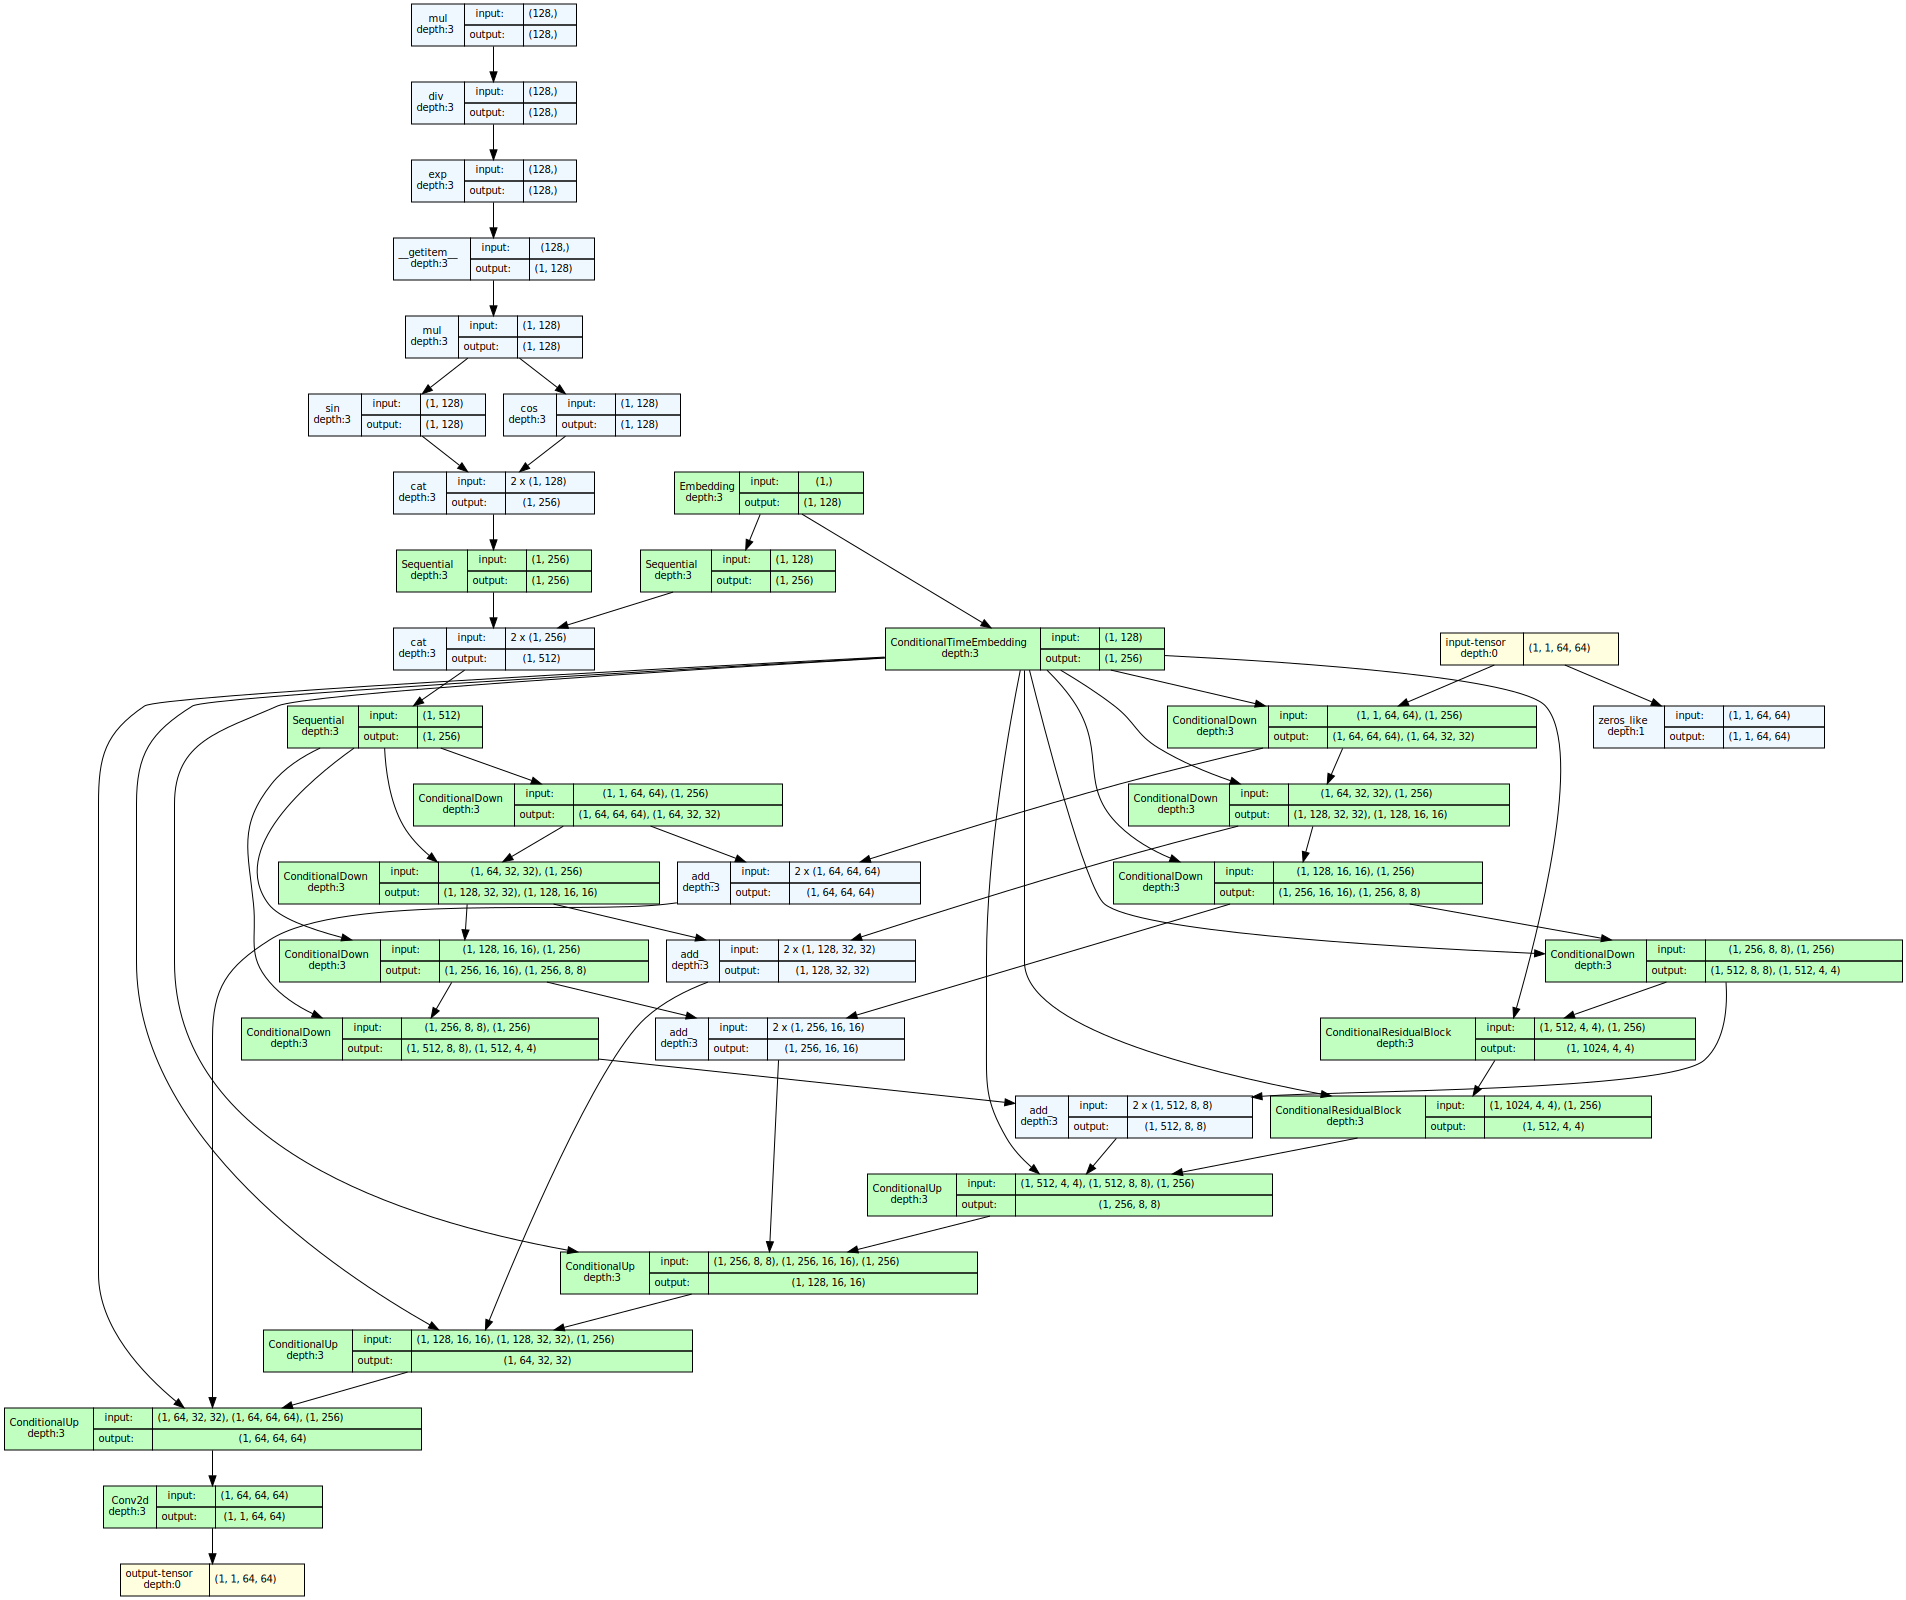

In [ ]:
# Visualização com Torchview
batch = next(iter(dataloader))
x_sample = batch['image'].to(device)
x_sample = x_sample[:1]

class WrappedNet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        t = torch.tensor([500], device=x.device)
        dummy_spatial = torch.zeros_like(x)
        dummy_label = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        return self.model(x, t, dummy_label, dummy_spatial)

wrapped_model = WrappedNet(model)
graph = draw_graph(wrapped_model, input_data=x_sample, graph_name="Condicionamento Espacial U-Net", roll=True)
graph.visual_graph

### **Condicionamento Epacial**

Agora implementamos diferentes formas de condicionamento espacial, destacando a flexibilidade do Controle Espacial para guiar a geração de imagens. Cada tipo de máscara binária é gerado com base em atributos derivados da própria imagem, resultando em padrões espaciais específicos que influenciam diretamente o processo de geração. Essas máscaras funcionam como guias estruturais, moldando o conteúdo gerado de acordo com características visuais relevantes.

In [ ]:
def create_spatial_condition(height, width, condition_type='intensity', image_tensor=None, threshold=0.2):
    device = image_tensor.device
    condition = torch.zeros(1, 1, height, width, device=device)

    img_tensor = image_tensor[0, 0].detach().cpu()
    img_uint8 = ((img_tensor + 1) * 127.5).clamp(0, 255).numpy().astype(np.uint8)

    if condition_type == 'intensity':
        thr = img_tensor.mean() + 0.1 * img_tensor.std()
        bin_mask = (img_tensor > thr).to(torch.uint8)
        condition[0, 0] = bin_mask.to(device)

    elif condition_type == 'low_intensity':
        thr = img_tensor.mean() - 0.2 * img_tensor.std()
        bin_mask = (img_tensor < thr).to(torch.uint8)
        condition[0, 0] = bin_mask.to(device)

    elif condition_type == 'edge':
        edges = cv2.Canny(img_uint8, 50, 150)
        bin_mask = (edges > 0).astype(np.uint8)
        condition = torch.from_numpy(bin_mask).unsqueeze(0).unsqueeze(0).to(device)

    elif condition_type == 'gradient':
        sobelx = cv2.Sobel(img_uint8.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_uint8.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
        grad_mag = np.sqrt(sobelx**2 + sobely**2)
        grad_norm = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min() + 1e-8)
        bin_mask = (grad_norm > threshold).astype(np.uint8)
        condition = torch.from_numpy(bin_mask).unsqueeze(0).unsqueeze(0).to(device)

    elif condition_type == 'scharr':
        scharrx = cv2.Scharr(img_uint8.astype(np.float32), cv2.CV_64F, 1, 0)
        scharry = cv2.Scharr(img_uint8.astype(np.float32), cv2.CV_64F, 0, 1)
        edges = np.sqrt(scharrx**2 + scharry**2)
        edges_norm = (edges - edges.min()) / (edges.max() - edges.min() + 1e-8)
        bin_mask = (edges_norm > threshold).astype(np.uint8)
        condition = torch.from_numpy(bin_mask).unsqueeze(0).unsqueeze(0).to(device)

    condition = condition.to(torch.float32)
    # Normalizar para [-1, 1]
    condition = condition * 2.0 - 1.0
    return condition


def create_average_spatial_condition(dataset, class_index, img_size, condition_type='intensity',
                                     samples_per_class=10, threshold=0.2):
    masks = []
    count = 0

    for sample in dataset:
        label = sample['label']
        if isinstance(label, torch.Tensor):
            label = label.item()
        if label == class_index:
            image_tensor = sample['image'].unsqueeze(0).to(device)  # [1, 1, H, W]
            cond = create_spatial_condition(img_size, img_size, condition_type, image_tensor, threshold)
            masks.append(cond)
            count += 1
            if count >= samples_per_class:
                break

    stacked = torch.cat(masks, dim=0)  # [N, 1, H, W]
    return stacked.mean(dim=0, keepdim=True)  # [1, 1, H, W]

Essas funções podem ser aplicadas individualmente (`create_spatial_condition`) ou de forma agregada para capturar um padrão médio da classe (`create_average_spatial_condition`), gerando uma condição espacial mais representativo, podendo ser salvo para ser usado como referência no deploy do modelo.

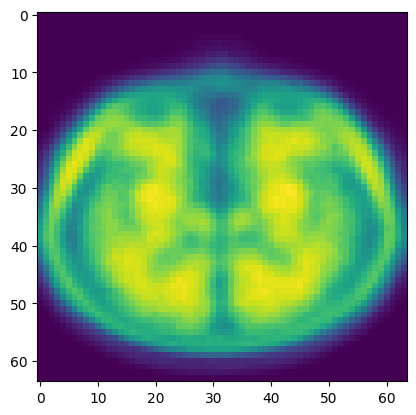

In [ ]:
cond0 = create_average_spatial_condition(dataset, 0, img_size,
                                         condition_type='intensity',
                                         samples_per_class=1_000) # usando 1000 imagens para gerar
plt.imshow(cond0[0, 0].cpu().numpy(), cmap='viridis');

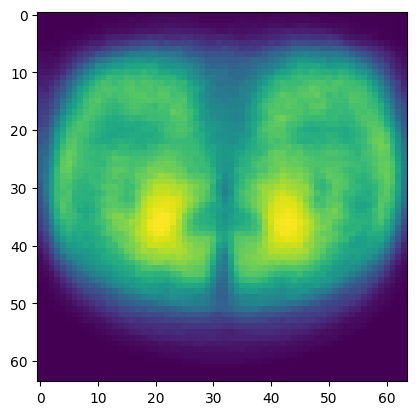

In [ ]:
cond1 = create_average_spatial_condition(dataset, 1, img_size,
                                         condition_type='intensity',
                                         samples_per_class=1_000)
plt.imshow(cond1[0, 0].cpu().numpy(), cmap='viridis');

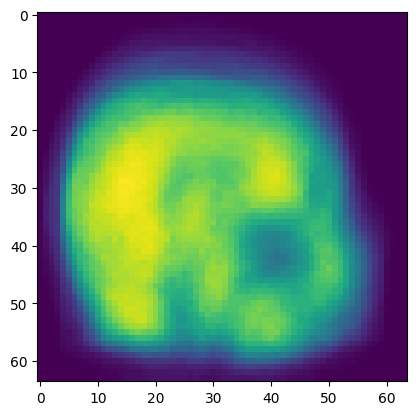

In [ ]:
cond2 = create_average_spatial_condition(dataset, 2, img_size,
                                         condition_type='intensity',
                                         samples_per_class=1_000)
plt.imshow(cond2[0, 0].cpu().numpy(), cmap='viridis');

In [ ]:
# Dicionário para acesso rápido dos condicionais
spatial_conditions_dict = {
    0: cond0,
    1: cond1,
    2: cond2
}

### **Experimentos**

Neste experimento, mantemos a simplicidade da função de perda original dos modelos DDPM, baseada no Erro Quadrático Médio (MSE) entre o ruído real e o ruído predito. No entanto, agora o modelo realiza a predição condicionada simultaneamente por dois fatores:

- Rótulos de classe, que fornecem orientação semântica;

- Máscaras espaciais, que fornecem orientação estrutural da imagem.

In [ ]:
### Função de Perda
def loss_fn_condspace(model, x0, labels, spatial_condition, t):
    noise = torch.randn_like(x0)
    x_t = q_sample(x0, t, noise)
    pred_noise = model(x_t, t, labels, spatial_condition)
    return F.mse_loss(pred_noise, noise)

#### **Treinamento do Modelo**

Aqui iremos seguir o mesmo pipeline do modelo da aula anterior, mas agora iremos coletar a região condicional do dicionário `spatial_conditions_dict` referente a cada label.

In [ ]:
def show_and_predict_conditional(model, labels, T, epoch=None):
    model.eval()
    class_index = labels[0].item()
    spatial_condition = spatial_conditions_dict[class_index].to(device)

    x = torch.randn(1, 1, img_size, img_size, device=device)
    for t in reversed(range(T)):
        x = p_sample_condspacial(model, x, t, labels, spatial_condition, guidance_scale=3.0)

    img = (x.clamp(-1, 1) + 1) / 2
    img = img[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype('uint8')

    # Visualização
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    if epoch is not None:
        class_name = dataset.idx_to_label[class_index]
        ax.text(2, 8, f"Época {epoch}", fontsize=12, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.9))
        ax.text(2, img_size - 8, f"Classe: {class_name}", fontsize=10, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.9))

    plt.tight_layout()
    plt.show()
    return img

Iniciando treinamento Condicionamento Espacial por 120 épocas...


Épocas:   0%|          | 0/120 [00:00<?, ?it/s]

Época 1:   0%|          | 0/61 [00:00<?, ?it/s]

Época 0, Perda: 0.2383


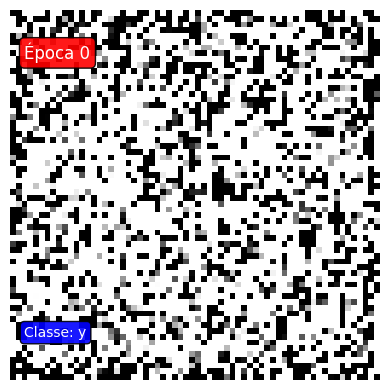

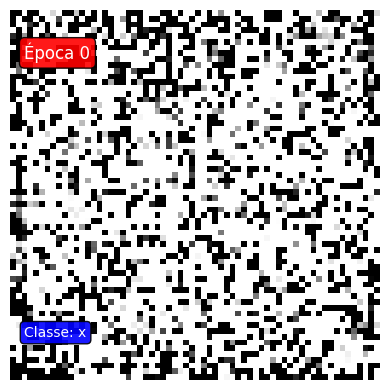

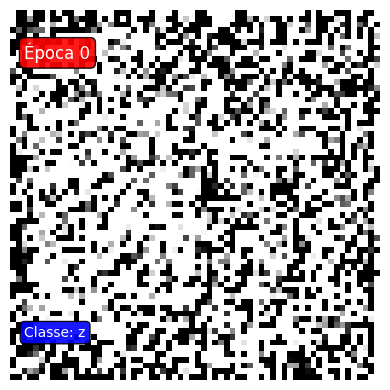

Época 2:   0%|          | 0/61 [00:00<?, ?it/s]

Época 3:   0%|          | 0/61 [00:00<?, ?it/s]

Época 4:   0%|          | 0/61 [00:00<?, ?it/s]

Época 5:   0%|          | 0/61 [00:00<?, ?it/s]

Época 6:   0%|          | 0/61 [00:00<?, ?it/s]

Época 7:   0%|          | 0/61 [00:00<?, ?it/s]

Época 8:   0%|          | 0/61 [00:00<?, ?it/s]

Época 9:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10:   0%|          | 0/61 [00:00<?, ?it/s]

Época 11:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10, Perda: 0.0288


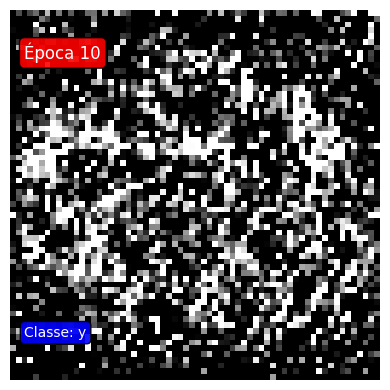

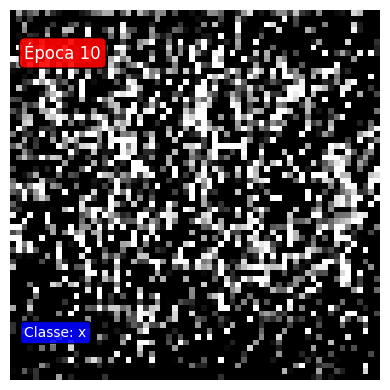

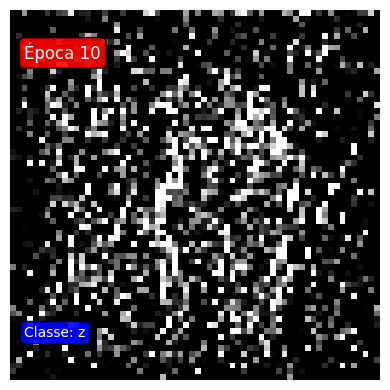

Época 12:   0%|          | 0/61 [00:00<?, ?it/s]

Época 13:   0%|          | 0/61 [00:00<?, ?it/s]

Época 14:   0%|          | 0/61 [00:00<?, ?it/s]

Época 15:   0%|          | 0/61 [00:00<?, ?it/s]

Época 16:   0%|          | 0/61 [00:00<?, ?it/s]

Época 17:   0%|          | 0/61 [00:00<?, ?it/s]

Época 18:   0%|          | 0/61 [00:00<?, ?it/s]

Época 19:   0%|          | 0/61 [00:00<?, ?it/s]

Época 20:   0%|          | 0/61 [00:00<?, ?it/s]

Época 21:   0%|          | 0/61 [00:00<?, ?it/s]

Época 20, Perda: 0.0263


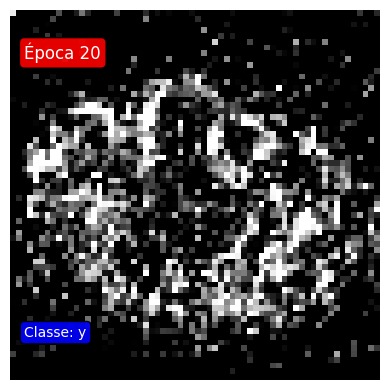

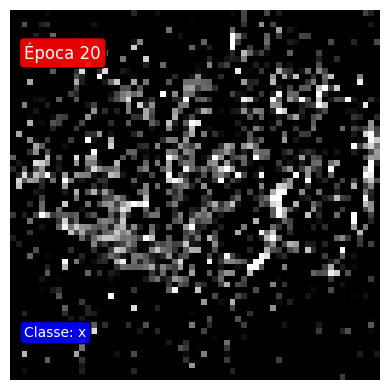

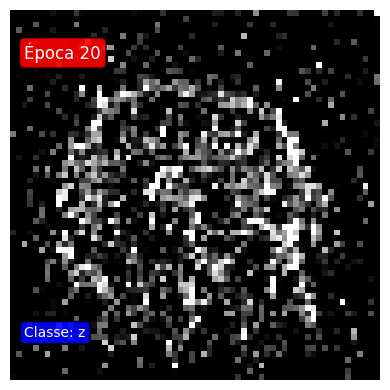

Época 22:   0%|          | 0/61 [00:00<?, ?it/s]

Época 23:   0%|          | 0/61 [00:00<?, ?it/s]

Época 24:   0%|          | 0/61 [00:00<?, ?it/s]

Época 25:   0%|          | 0/61 [00:00<?, ?it/s]

Época 26:   0%|          | 0/61 [00:00<?, ?it/s]

Época 27:   0%|          | 0/61 [00:00<?, ?it/s]

Época 28:   0%|          | 0/61 [00:00<?, ?it/s]

Época 29:   0%|          | 0/61 [00:00<?, ?it/s]

Época 30:   0%|          | 0/61 [00:00<?, ?it/s]

Época 31:   0%|          | 0/61 [00:00<?, ?it/s]

Época 30, Perda: 0.0260


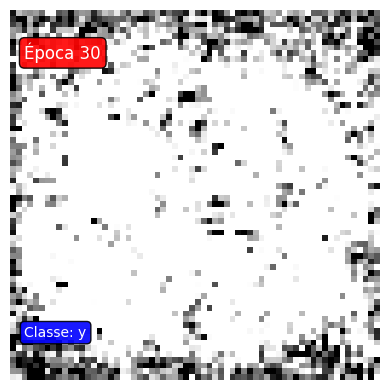

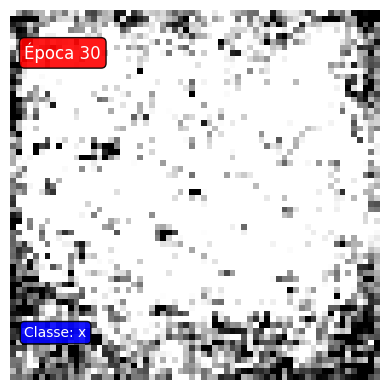

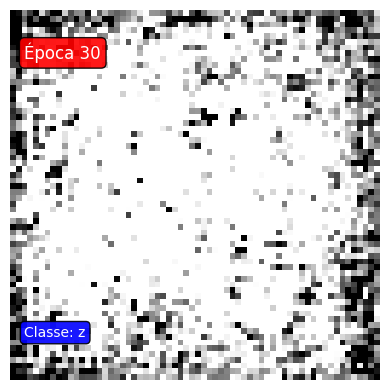

Época 32:   0%|          | 0/61 [00:00<?, ?it/s]

Época 33:   0%|          | 0/61 [00:00<?, ?it/s]

Época 34:   0%|          | 0/61 [00:00<?, ?it/s]

Época 35:   0%|          | 0/61 [00:00<?, ?it/s]

Época 36:   0%|          | 0/61 [00:00<?, ?it/s]

Época 37:   0%|          | 0/61 [00:00<?, ?it/s]

Época 38:   0%|          | 0/61 [00:00<?, ?it/s]

Época 39:   0%|          | 0/61 [00:00<?, ?it/s]

Época 40:   0%|          | 0/61 [00:00<?, ?it/s]

Época 41:   0%|          | 0/61 [00:00<?, ?it/s]

Época 40, Perda: 0.0238


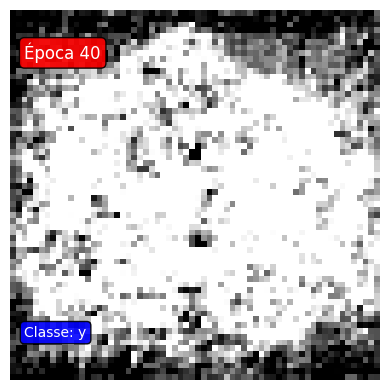

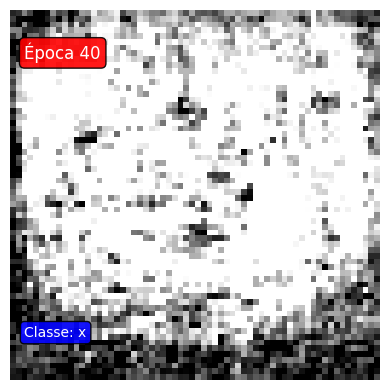

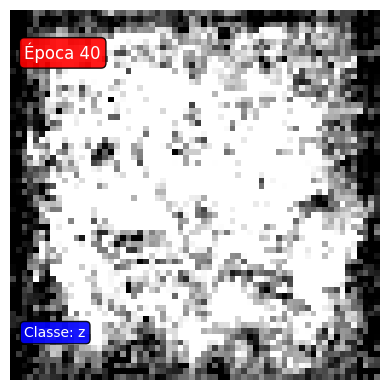

Época 42:   0%|          | 0/61 [00:00<?, ?it/s]

Época 43:   0%|          | 0/61 [00:00<?, ?it/s]

Época 44:   0%|          | 0/61 [00:00<?, ?it/s]

Época 45:   0%|          | 0/61 [00:00<?, ?it/s]

Época 46:   0%|          | 0/61 [00:00<?, ?it/s]

Época 47:   0%|          | 0/61 [00:00<?, ?it/s]

Época 48:   0%|          | 0/61 [00:00<?, ?it/s]

Época 49:   0%|          | 0/61 [00:00<?, ?it/s]

Época 50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 51:   0%|          | 0/61 [00:00<?, ?it/s]

Época 50, Perda: 0.0247


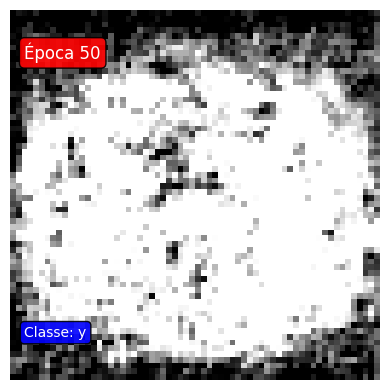

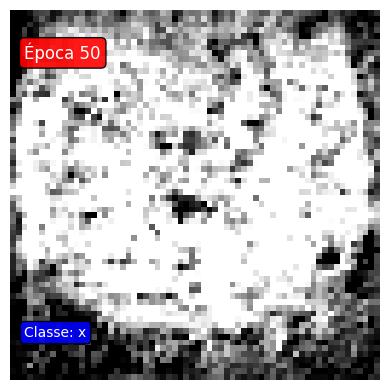

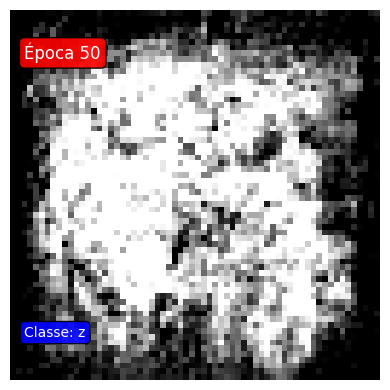

Época 52:   0%|          | 0/61 [00:00<?, ?it/s]

Época 53:   0%|          | 0/61 [00:00<?, ?it/s]

Época 54:   0%|          | 0/61 [00:00<?, ?it/s]

Época 55:   0%|          | 0/61 [00:00<?, ?it/s]

Época 56:   0%|          | 0/61 [00:00<?, ?it/s]

Época 57:   0%|          | 0/61 [00:00<?, ?it/s]

Época 58:   0%|          | 0/61 [00:00<?, ?it/s]

Época 59:   0%|          | 0/61 [00:00<?, ?it/s]

Época 60:   0%|          | 0/61 [00:00<?, ?it/s]

Época 61:   0%|          | 0/61 [00:00<?, ?it/s]

Época 60, Perda: 0.0229


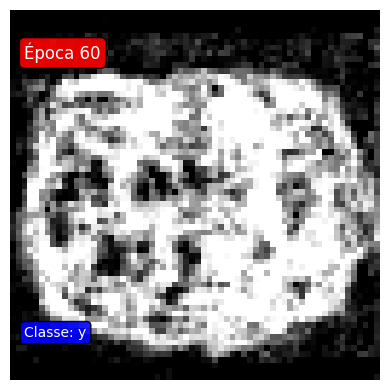

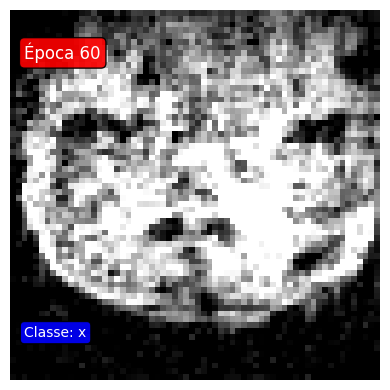

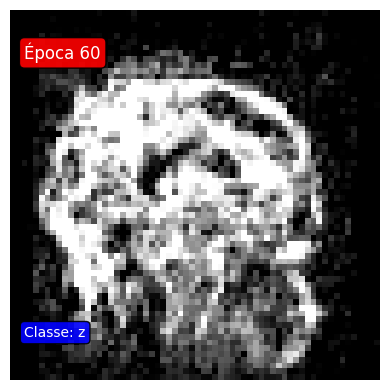

Época 62:   0%|          | 0/61 [00:00<?, ?it/s]

Época 63:   0%|          | 0/61 [00:00<?, ?it/s]

Época 64:   0%|          | 0/61 [00:00<?, ?it/s]

Época 65:   0%|          | 0/61 [00:00<?, ?it/s]

Época 66:   0%|          | 0/61 [00:00<?, ?it/s]

Época 67:   0%|          | 0/61 [00:00<?, ?it/s]

Época 68:   0%|          | 0/61 [00:00<?, ?it/s]

Época 69:   0%|          | 0/61 [00:00<?, ?it/s]

Época 70:   0%|          | 0/61 [00:00<?, ?it/s]

Época 71:   0%|          | 0/61 [00:00<?, ?it/s]

Época 70, Perda: 0.0226


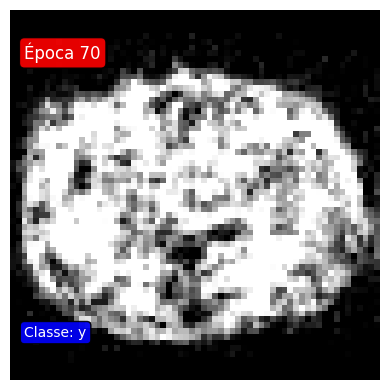

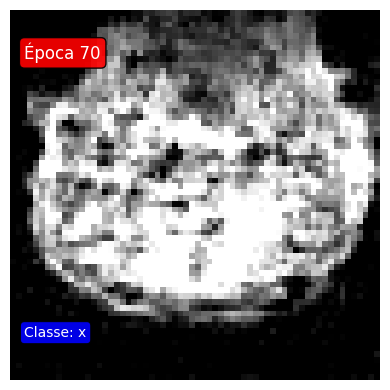

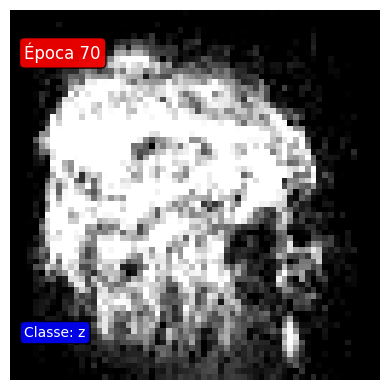

Época 72:   0%|          | 0/61 [00:00<?, ?it/s]

Época 73:   0%|          | 0/61 [00:00<?, ?it/s]

Época 74:   0%|          | 0/61 [00:00<?, ?it/s]

Época 75:   0%|          | 0/61 [00:00<?, ?it/s]

Época 76:   0%|          | 0/61 [00:00<?, ?it/s]

Época 77:   0%|          | 0/61 [00:00<?, ?it/s]

Época 78:   0%|          | 0/61 [00:00<?, ?it/s]

Época 79:   0%|          | 0/61 [00:00<?, ?it/s]

Época 80:   0%|          | 0/61 [00:00<?, ?it/s]

Época 81:   0%|          | 0/61 [00:00<?, ?it/s]

Época 80, Perda: 0.0226


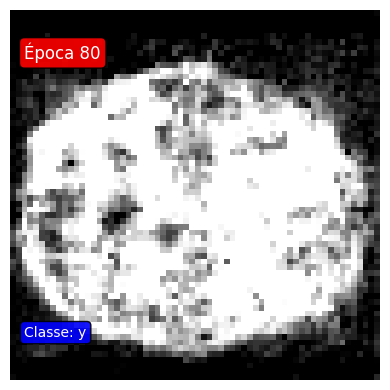

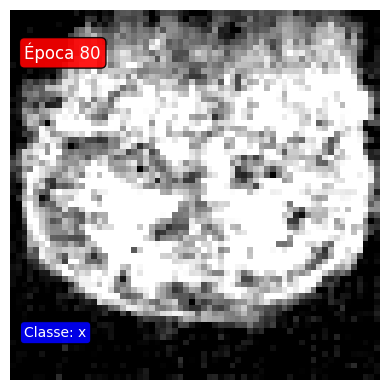

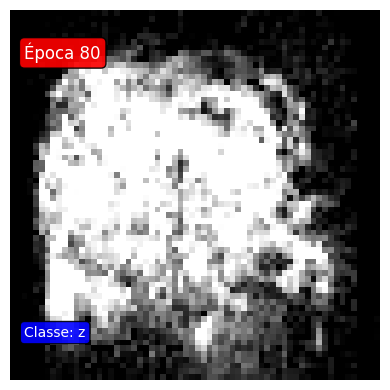

Época 82:   0%|          | 0/61 [00:00<?, ?it/s]

Época 83:   0%|          | 0/61 [00:00<?, ?it/s]

Época 84:   0%|          | 0/61 [00:00<?, ?it/s]

Época 85:   0%|          | 0/61 [00:00<?, ?it/s]

Época 86:   0%|          | 0/61 [00:00<?, ?it/s]

Época 87:   0%|          | 0/61 [00:00<?, ?it/s]

Época 88:   0%|          | 0/61 [00:00<?, ?it/s]

Época 89:   0%|          | 0/61 [00:00<?, ?it/s]

Época 90:   0%|          | 0/61 [00:00<?, ?it/s]

Época 91:   0%|          | 0/61 [00:00<?, ?it/s]

Época 90, Perda: 0.0222


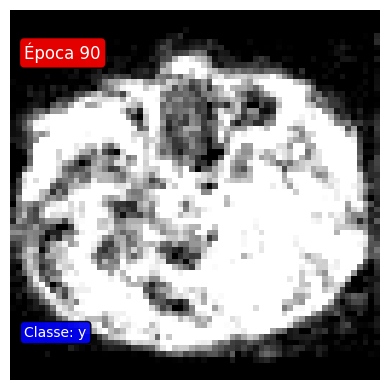

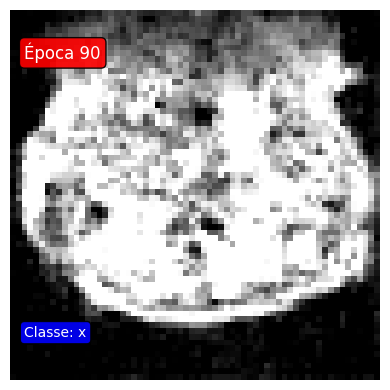

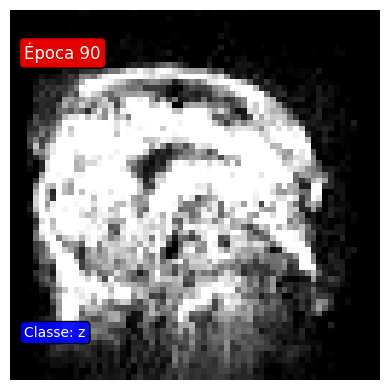

Época 92:   0%|          | 0/61 [00:00<?, ?it/s]

Época 93:   0%|          | 0/61 [00:00<?, ?it/s]

Época 94:   0%|          | 0/61 [00:00<?, ?it/s]

Época 95:   0%|          | 0/61 [00:00<?, ?it/s]

Época 96:   0%|          | 0/61 [00:00<?, ?it/s]

Época 97:   0%|          | 0/61 [00:00<?, ?it/s]

Época 98:   0%|          | 0/61 [00:00<?, ?it/s]

Época 99:   0%|          | 0/61 [00:00<?, ?it/s]

Época 100:   0%|          | 0/61 [00:00<?, ?it/s]

Época 101:   0%|          | 0/61 [00:00<?, ?it/s]

Época 100, Perda: 0.0218


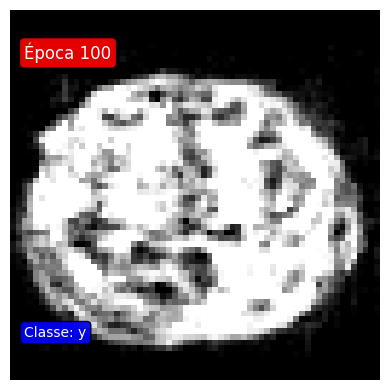

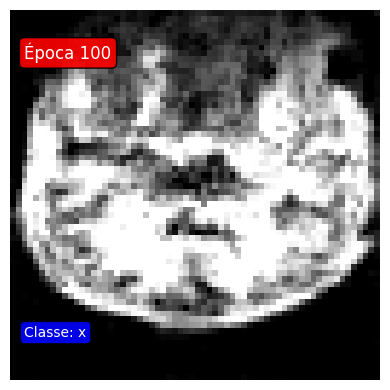

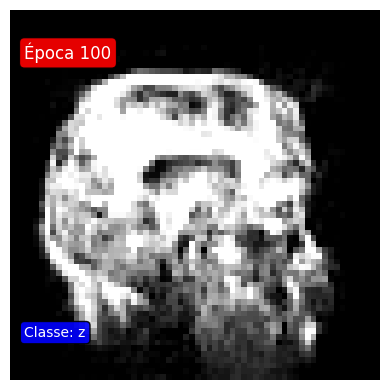

Época 102:   0%|          | 0/61 [00:00<?, ?it/s]

Época 103:   0%|          | 0/61 [00:00<?, ?it/s]

Época 104:   0%|          | 0/61 [00:00<?, ?it/s]

Época 105:   0%|          | 0/61 [00:00<?, ?it/s]

Época 106:   0%|          | 0/61 [00:00<?, ?it/s]

Época 107:   0%|          | 0/61 [00:00<?, ?it/s]

Época 108:   0%|          | 0/61 [00:00<?, ?it/s]

Época 109:   0%|          | 0/61 [00:00<?, ?it/s]

Época 110:   0%|          | 0/61 [00:00<?, ?it/s]

Época 111:   0%|          | 0/61 [00:00<?, ?it/s]

Época 110, Perda: 0.0232


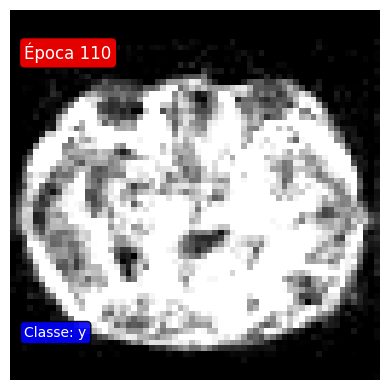

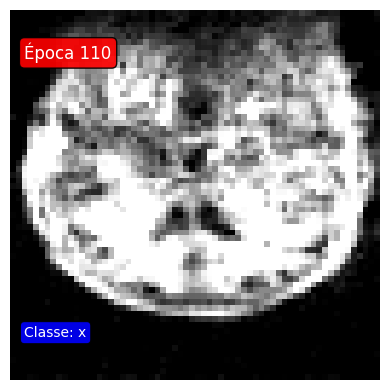

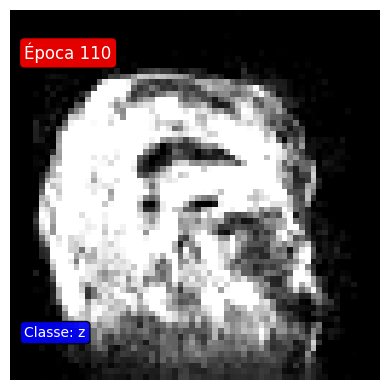

Época 112:   0%|          | 0/61 [00:00<?, ?it/s]

Época 113:   0%|          | 0/61 [00:00<?, ?it/s]

Época 114:   0%|          | 0/61 [00:00<?, ?it/s]

Época 115:   0%|          | 0/61 [00:00<?, ?it/s]

Época 116:   0%|          | 0/61 [00:00<?, ?it/s]

Época 117:   0%|          | 0/61 [00:00<?, ?it/s]

Época 118:   0%|          | 0/61 [00:00<?, ?it/s]

Época 119:   0%|          | 0/61 [00:00<?, ?it/s]

Época 120:   0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
### Loop de Treinamento
epochs = 120
print(f"Iniciando treinamento Condicionamento Espacial por {epochs} épocas...")
frames = []
model.train()

for epoch in tqdm(range(epochs), desc="Épocas"):
    epoch_loss = 0
    num_batches = 0

    for batch in tqdm(dataloader, desc=f"Época {epoch+1}", leave=False):
        optimizer.zero_grad()

        x0 = batch['image'].to(device)          # [B, 1, H, W]
        labels = batch['label'].to(device)      # [B]
        t = torch.randint(0, T, (x0.shape[0],), device=device)

        # Recupera a condição espacial média correspondente a cada rótulo do batch
        spatial_conditions = []
        for label in labels.cpu().tolist():
            cond = spatial_conditions_dict[label]  # [1, 1, H, W]
            spatial_conditions.append(cond)
        spatial_condition = torch.cat(spatial_conditions, dim=0).to(device)  # [B, 1, H, W]

        with autocast(device_type='cuda'):
            loss = loss_fn_condspace(model, x0, labels, spatial_condition, t)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches

    # Visualização a cada época
    if epoch % 10 == 0:
        print(f"Época {epoch}, Perda: {avg_loss:.4f}")

        with torch.no_grad():
            test_class = [0, 1, 2]
            frame_list = []

            for classe in test_class:
                test_labels = torch.tensor([int(classe)], device=device)
                frame = show_and_predict_conditional(model, test_labels, T, epoch)
                frame_list.append(frame)  # Armazena cada imagem individual

            # Concatenar horizontalmente
            concatenated_frame = np.concatenate(frame_list, axis=1)
            frames.append(concatenated_frame)

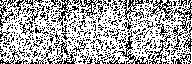

In [ ]:
# Salva GIF do progresso
gif_frames = []
font = ImageFont.load_default()
for i, frame in enumerate(frames):
    img_pil = Image.fromarray(np.repeat(frame, 3, axis=2))
    gif_frames.append(np.array(img_pil))

imageio.mimsave("controlnet_training.gif", gif_frames, fps=2, loop=0)
Im2("controlnet_training.gif", width=500)

In [ ]:
### Geração Condicional por Etapas
def generate_controlnet_diffusion_gif(model, test_class, num_samples=6):
    frames = []
    test_labels = torch.tensor([test_class] * num_samples, device=device)
    spatial_condition = spatial_conditions_dict[test_class].expand(num_samples, -1, -1, -1).to(device)

    x = torch.randn(num_samples, 1, img_size, img_size, device=device)

    for t in reversed(range(T)):
        x = p_sample_condspacial(model, x, t, test_labels, spatial_condition, guidance_scale=3.0)
        if t % 50 == 0 or t < 5:
            imgs = [im.cpu().detach() for im in x]
            pad = torch.ones((1, img_size, 2))
            concat_list = []
            for i, img in enumerate(imgs):
                concat_list.append(img)
                if i < len(imgs) - 1:
                    concat_list.append(pad)
            img_grid = torch.cat(concat_list, dim=2).permute(1, 2, 0)
            img_grid = (img_grid.clamp(-1, 1) + 1) / 2
            frames.append((img_grid.numpy() * 255).astype('uint8'))

    gif = [np.concatenate([frame] * 3, axis=2) for frame in frames]
    filename = f"controlnet_diffusion_process_{test_class}.gif"
    imageio.mimsave(filename, gif, fps=4, loop=0)
    return Im2(filename=filename, width=700)

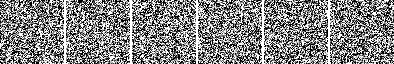

In [ ]:
# Executar para uma classe 0
generate_controlnet_diffusion_gif(model, test_class=0)

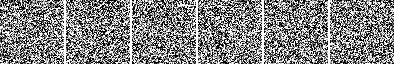

In [ ]:
# Executar para uma classe 1
generate_controlnet_diffusion_gif(model, test_class=1)

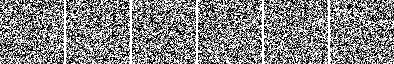

In [ ]:
# Executar para uma classe 2
generate_controlnet_diffusion_gif(model, test_class=2)

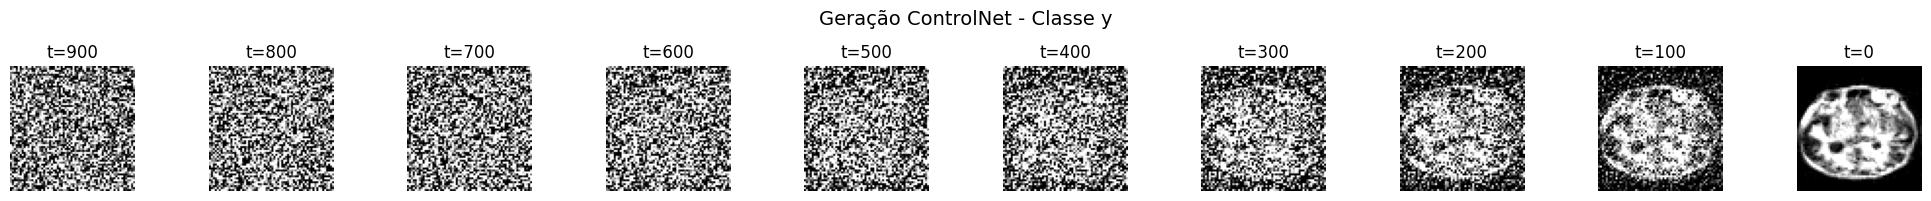

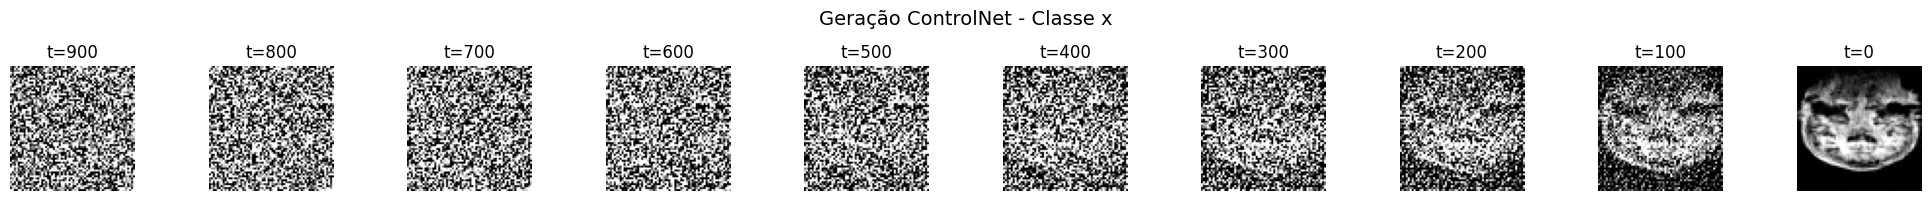

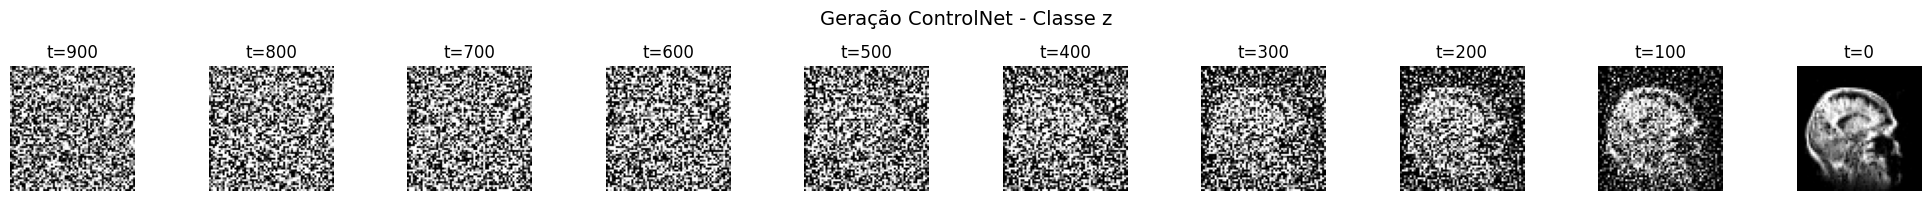

In [ ]:
# Analisar progresso ao longo do tempo
def analyze_controlnet_progress(model, test_class):
    model.eval()
    test_labels = torch.tensor([test_class], device=device)
    spatial_condition = spatial_conditions_dict[test_class].to(device)

    x = torch.randn(1, 1, img_size, img_size, device=device)
    imgs, steps = [], []

    for t in reversed(range(T)):
        x = p_sample_condspacial(model, x, t, test_labels, spatial_condition, guidance_scale=3.0)
        if t % 100 == 0 or t == 0:
            img_vis = (x.clamp(-1, 1) + 1) / 2
            imgs.append(img_vis[0].detach().cpu())
            steps.append(t)

    fig, axs = plt.subplots(1, len(imgs), figsize=(2 * len(imgs), 2))
    for i, (img, t_val) in enumerate(zip(imgs, steps)):
        axs[i].imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"t={t_val}")
    plt.suptitle(f"Geração ControlNet - Classe {dataset.idx_to_label[test_class]}", fontsize=14)
    plt.tight_layout()
    plt.show()


# Executar análise
test_classes = [0, 1, 2]
for classe in test_classes:
    final_progress = analyze_controlnet_progress(model, test_class=classe)